<a href="https://colab.research.google.com/github/Ludvins/VC/blob/master/Practica%202/Cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import keras.utils as np_utils
# Import optimizer
from keras.optimizers import SGD
# Import data
from keras.datasets import cifar100
# Import models and layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
# Import image proprocessors
from keras.preprocessing.image import ImageDataGenerator
# Show no TensorFlow deprecation warnings
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)

## Auxiliar functions

Loads Cifar data.

In [0]:
def load_cifar_data():
    # Load Data
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # Transform to float and normalize
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    # We will use only 25 classes.
    train_idx = np.isin(y_train, np.arange(25))
    train_idx = np.reshape(train_idx, -1)
    x_train = x_train[train_idx]
    y_train = y_train[train_idx]
    test_idx = np.isin(y_test, np.arange(25))
    test_idx = np.reshape(test_idx, -1)
    x_test = x_test[test_idx]
    y_test = y_test[test_idx]
    
    # Set labels to cathegorical
    y_train = np_utils.to_categorical(y_train, 25)
    y_test = np_utils.to_categorical(y_test, 25)
    
    return x_train, y_train, x_test, y_test

Shows model results in test partition.

In [0]:
def evaluate(model, x_test, y_test, verbose = 0):
    score = model.evaluate(x_test, y_test, verbose=verbose)
    print("# TEST RESULTS")
    print('Test loss: ', score[0])
    print('Test accuracy: ', score[1])

Draws two graphics.
+ Loss function evolution.
+ Accuracy function evolution.

Args:
+ ```hist```: Training records

In [0]:
def show_evolution(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.show()

Draws the same graphics as ```show_evolution``` but using a list of records ```hist```.

In [0]:
def show_evolution(hist, names):

    for i in hist:
        val_loss = i.history['val_loss']
        plt.plot(val_loss)

    plt.legend(["Validation loss " + names[i] for i in range(len(hist))])
    plt.show()

    for i in hist:
        val_acc = i.history['val_acc']
        plt.plot(val_acc)

    plt.legend(["Validation accuracy " + names[i] for i in range(len(hist))])
    plt.show()

## Data generators

In [0]:
def basic_data_generator():
    datagen = ImageDataGenerator(validation_split = 0.1)
    return datagen

In [0]:
def complex_data_generator():
  datagen = ImageDataGenerator(
      featurewise_center = True,             # set input mean to 0 over the dataset
      samplewise_center = False,             # set each sample mean to 0
      featurewise_std_normalization = True,  # divide inputs by std of the dataset
      samplewise_std_normalization = False,  # divide each input by its std
      zca_whitening = False,                 # apply ZCA whitening
      zca_epsilon = 1e-06,                   # epsilon for ZCA whitening
      rotation_range = 0,                    # randomly rotate images in the range (degrees, 0 to 180)
      width_shift_range = 0.1,               # randomly shift images horizontally (fraction of total width)
      height_shift_range = 0.1,              # randomly shift images vertically (fraction of total height)
      shear_range = 0.,                      # set range for random shear
      zoom_range = 0.,                       # set range for random zoom
      channel_shift_range = 0.,              # set range for random channel shifts
      fill_mode = 'nearest',                 # set mode for filling points outside the input boundaries
      cval = 0.,                             # value used for fill_mode = "constant"
      horizontal_flip = True,                # randomly flip images
      vertical_flip = False,                 # randomly flip images
      rescale = None,                        # set rescaling factor (applied before any other transformation)
      preprocessing_function = None,         # set function that will be applied on each input
      data_format = None,                    # image data format, either "channels_first" or "channels_last"
      validation_split = 0.1)                # fraction of images reserved for validation (strictly between 0 and 1)
  return datagen

## Model definitions

In [0]:
def base_net_model(name = 'BaseNet Model'):
    model = Sequential()
    model.name = name
    model.add(Conv2D(6, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5,5), 
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='softmax'))
    
    return model

In [0]:
def base_net_model2(name = 'BaseNet Model 2'):
    model = Sequential()
    model.name = name
    model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape=(32,32,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))

    return model

## Train function

In [0]:
def train_and_evaluate(model, data_generator, batch_size, epochs, verbose = 0):

    model.compile(
        loss = keras.losses.categorical_crossentropy,
        optimizer = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True),
        metrics = ['accuracy']
    )

    x_train, y_train, x_test, y_test = load_cifar_data()
    datagen = data_generator()
    datagen.fit(x_train)
    datagen.standardize(x_test)

    h = model.fit_generator(
                datagen.flow(x_train, y_train, batch_size, subset='training'),
                steps_per_epoch = len(x_train)*0.9/batch_size,
                epochs = epochs,
                validation_data = datagen.flow(x_train, y_train, batch_size, subset='validation'),
                validation_steps = len(x_train)*0.1/batch_size,
                verbose = verbose
                )
    evaluate(model, x_test, y_test)
    return h
    


# Main functions

In [24]:
# Ejercicio 1
m1 = base_net_model()
m1.summary()
h1 = train_and_evaluate(m1, basic_data_generator, 32, 20)

Model: "BaseNet Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                20050     
_________________________________________________________________
dense_6 (Dense)              (None, 25)              

# TEST RESULTS
Test loss:  1.8870376762390138
Test accuracy:  0.4516


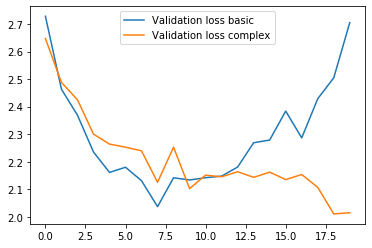

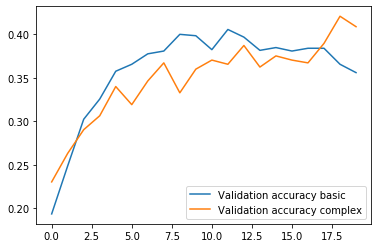

Model: "BaseNet Model 2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)      

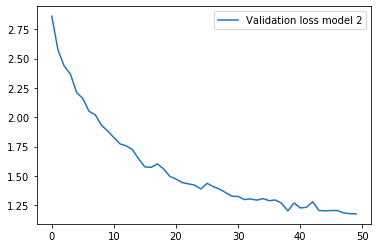

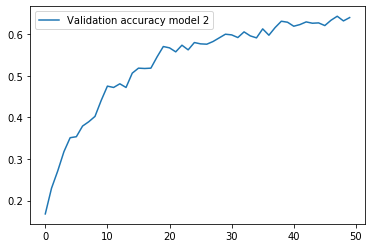

In [25]:
# Ejercicio 2
m2 = base_net_model()
h2 = train_and_evaluate(m2, complex_data_generator, 32, 20)

show_evolution([h1, h2], ["basic", "complex"])

m3 = base_net_model2()
m3.summary()
h3 = train_and_evaluate(m3, complex_data_generator, 128, 50)

show_evolution([h3], ["model 2"])